In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import sys, os

from scipy.sparse.linalg import eigsh
from scipy.sparse import diags_array

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from notebook_functions import load_data

In [23]:
def convg_plot(path, eta, dg, globalref, localref, threshold_global_local, lfc_degrees_and_markers, lower_limit=1e-8, upper_limit=1e-2, leapfrog_on_coarse_cfl=None):
    if leapfrog_on_coarse_cfl:
        plt.vlines(leapfrog_on_coarse_cfl, lower_limit, upper_limit, linestyles='dashed', colors='k')

    data = pd.read_table(path + 'errors_time_cavity_LTS_LFC_eta' + str(eta).replace('.', ',') + '_dg' + str(dg) + '_globalref' + str(globalref) + '_localref' + str(localref) + '_threshold' + str(threshold_global_local).replace('.', ',') + '.txt', sep='|')
    data.drop(columns=data.columns[0], axis=1, inplace=True)
    data.columns = data.columns.str.strip()
        
    stepsizes = data['time step width'].unique()
    mask_large_vals = data['max l2 error'] >= 100
    data.loc[mask_large_vals, 'max l2 error'] = 1e20

    lfc_degrees = lfc_degrees_and_markers.keys()

    for lfc_degree, color in zip(lfc_degrees, list(mcolors.TABLEAU_COLORS)):
        mask_lfc_degree = data['lfc degree'] == lfc_degree
        errors = data.loc[mask_lfc_degree, 'max l2 error']
        if lfc_degree == 1:
            label = "leapfrog"
        else:
            label = r"$p = $" + str(lfc_degree)
        plt.loglog(stepsizes, errors, marker=lfc_degrees_and_markers[lfc_degree], linestyle='-',color=color, label=label)

    # order line
    ord_2_line = 0.05 * errors.values[-1] / stepsizes[-1]**2
    plt.loglog(stepsizes, ord_2_line*stepsizes**2, linestyle='--', color='gray', label=r'$\mathcal{O}(\tau^2)$')
    
    plt.legend(loc='upper left')
    plt.ylabel(r"max $L^2$-error")
    plt.xlabel(r"time stepsize $\tau$")
    plt.ylim((lower_limit, upper_limit))
    plt.tight_layout()
    plt.show()

#### Cavity

In [7]:
matrix_path = "../../build/TE-example/convergence/matrices/"
plot_data_path = "../../build/TE-example/convergence/"

localref = 3
globalref = 3
dg = 5
threshold_global_to_local = 1.2
eta = 1

data_str = "_dg" + str(dg) + "_globalref" + str(globalref) + "_localref" + str(localref)

In [8]:
indH, indE, mass_H, mass_E, inv_mass_H, inv_mass_E, curl_H, curl_E = load_data(matrix_path, data_str)
cutoff_nonstiff = diags_array(np.concatenate((np.ones(indH[2]), np.zeros(indH[4] - indH[2])), axis=None), format='csr')
nonstiff_curl_curl = -curl_H @ inv_mass_H @ cutoff_nonstiff @ curl_E
vals_nonstiff, vecs = eigsh(A=nonstiff_curl_curl, M=mass_E, Minv=inv_mass_E, k=6, which='LM')

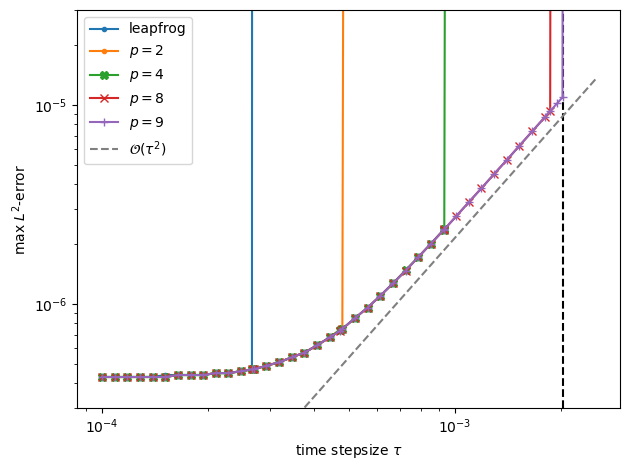

In [24]:
lfc_degrees_and_markers = {1 : '.', 2 : '.', 4 : 'X', 8 : 'x', 9 : '+'}

convg_plot(plot_data_path, eta, dg, globalref, localref, threshold_global_to_local, lfc_degrees_and_markers=lfc_degrees_and_markers, lower_limit=3e-7, upper_limit=3e-5, leapfrog_on_coarse_cfl=np.sqrt(4 / np.max(vals_nonstiff)))